<a href="https://colab.research.google.com/github/shanks5017/Finished-Customer-Satisfaction-Prediction-ML-_-FA-_-DA-projects-.ipynb/blob/main/Shashank%20Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Setup & Load Data

# === Import Required Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For ML later
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# === Upload CSV File from Device ===
from google.colab import files
uploaded = files.upload()

# Get uploaded file name
file_name = list(uploaded.keys())[0]

# === Load Dataset ===
df = pd.read_csv(file_name)

# === Basic Exploration ===
print("✅ Dataset Loaded Successfully!")
print("Shape of dataset:", df.shape)

# Display first 10 rows
print("\nFirst 10 rows:")
print(df.head(10))

# Info about dataset
print("\nDataset Info:")
print(df.info())

# Check missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Basic Statistics
print("\nSummary Statistics:")
print(df.describe(include='all'))


Saving customer_support_tickets.csv to customer_support_tickets.csv
✅ Dataset Loaded Successfully!
Shape of dataset: (8469, 17)

First 10 rows:
   Ticket ID        Customer Name              Customer Email  Customer Age  \
0          1        Marisa Obrien  carrollallison@example.com            32   
1          2         Jessica Rios    clarkeashley@example.com            42   
2          3  Christopher Robbins   gonzalestracy@example.com            48   
3          4     Christina Dillon    bradleyolson@example.org            27   
4          5    Alexander Carroll     bradleymark@example.com            67   
5          6      Rebecca Fleming     sheenasmith@example.com            53   
6          7    Jacqueline Wright     donaldkeith@example.org            24   
7          8           Denise Lee    joelwilliams@example.com            23   
8          9       Nicolas Wilson        joshua24@example.com            60   
9         10       William Dawson          clopez@example.com     

In [ ]:
# STEP 2: Data Preprocessing

import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# 1. Drop Non-informative Columns
drop_cols = ['Ticket ID','Customer Name','Customer Email']  # adjust based on your dataset
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

# 2. Convert Dates & Extract Durations
date_cols = ['Created Date','First Response Date','Resolved Date']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

if all(x in df.columns for x in ['Created Date','First Response Date']):
    df['response_delay_hours'] = (df['First Response Date'] - df['Created Date']).dt.total_seconds() / 3600

if all(x in df.columns for x in ['Created Date','Resolved Date']):
    df['resolution_time_hours'] = (df['Resolved Date'] - df['Created Date']).dt.total_seconds() / 3600

# 3. Encode Categorical Variables
cat_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_cols:
    try:
        df[col] = le.fit_transform(df[col].astype(str))
    except:
        pass

# 4. Handle Missing Values
for col in df.columns:
    if df[col].dtype in ['int64','float64']:
        df[col].fillna(df[col].median(), inplace=True)
    else:
        df[col].fillna(df[col].mode()[0], inplace=True)

# 5. Clean Text Fields
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [w for w in text.split() if w not in stop_words]
    return " ".join(tokens)

for col in ['Subject','Description']:
    if col in df.columns:
        df[col] = df[col].apply(clean_text)

# 6. Data Quality Report
data_quality = pd.DataFrame({
    'DataType': df.dtypes,
    'MissingValues': df.isnull().sum(),
    'MissingPercent': round(df.isnull().mean()*100, 2),
    'UniqueValues': df.nunique()
})

print("✅ Data Preprocessing Completed!")
print("\nData Quality Report (first 20 columns):")
print(data_quality.head(20))

# 7. Save Cleaned Dataset
df.to_csv("cleaned_data.csv", index=False)
print("\n💾 Cleaned dataset saved as cleaned_data.csv")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/tmp/ipython-input-3580076419.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


✅ Data Preprocessing Completed!

Data Quality Report (first 20 columns):
                             DataType  MissingValues  MissingPercent  \
Customer Age                    int64              0             0.0   
Customer Gender                 int64              0             0.0   
Product Purchased               int64              0             0.0   
Date of Purchase                int64              0             0.0   
Ticket Type                     int64              0             0.0   
Ticket Subject                  int64              0             0.0   
Ticket Description              int64              0             0.0   
Ticket Status                   int64              0             0.0   
Resolution                      int64              0             0.0   
Ticket Priority                 int64              0             0.0   
Ticket Channel                  int64              0             0.0   
First Response Time             int64              0           

✅ Using target column: Customer Satisfaction Rating


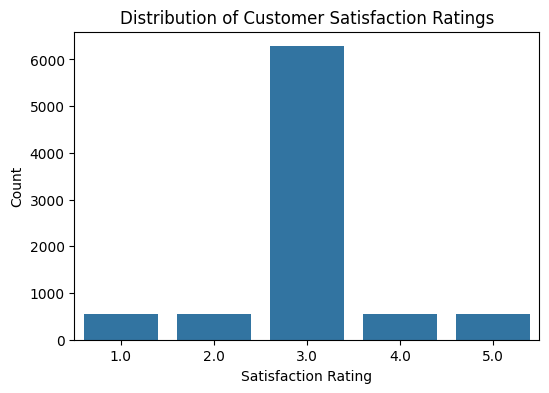

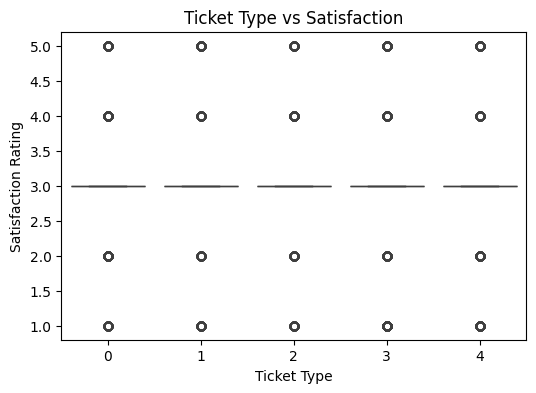

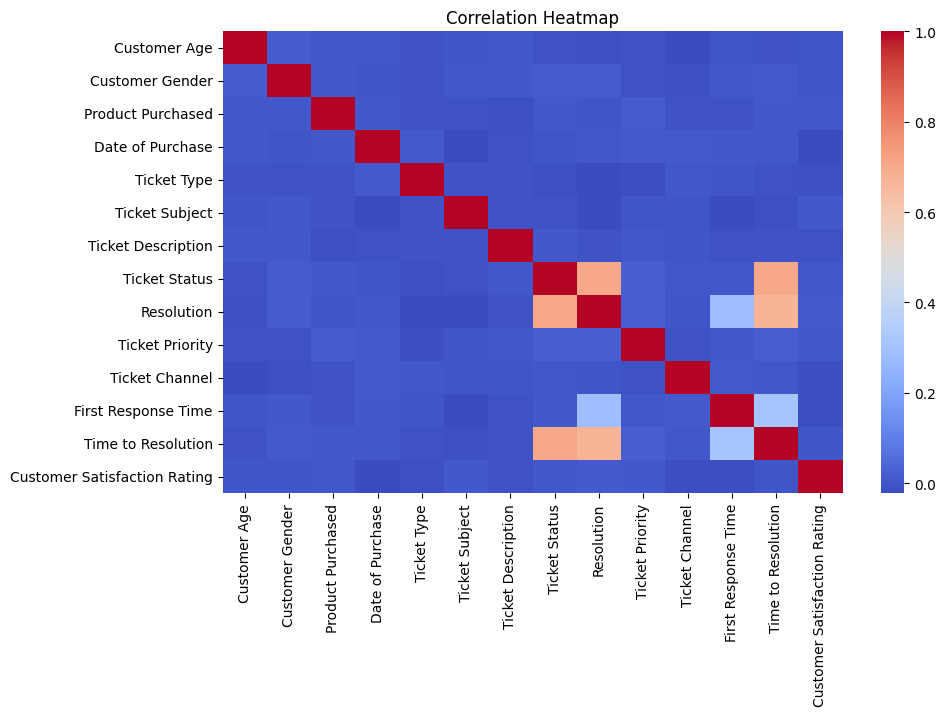

✅ EDA Completed!

📊 Insights:
- Age distribution shows which customer segments dominate the dataset.
- Satisfaction distribution reveals balance/imbalance in target classes.
- Resolution time distribution shows typical support speed.
- Age vs Satisfaction: detects if younger/older customers differ in rating.
- Ticket Type & Channel vs Satisfaction: which services perform best.
- Correlation heatmap: highlights numerical feature relationships.
- Time trends: ticket volume growth/decline over time.


In [ ]:
# STEP 3: Exploratory Data Analysis (EDA)

import seaborn as sns
import matplotlib.pyplot as plt

# Detect target column (Satisfaction)
target_candidates = [c for c in df.columns if "satisfaction" in c.lower()]
if len(target_candidates) == 0:
    raise ValueError("❌ No column with 'satisfaction' found. Please check your dataset columns.")
target_col = target_candidates[0]
print(f"✅ Using target column: {target_col}")

# 1. Univariate Analysis
if 'Age' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['Age'], bins=20, kde=True)
    plt.title("Distribution of Customer Age")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title("Distribution of Customer Satisfaction Ratings")
plt.xlabel("Satisfaction Rating")
plt.ylabel("Count")
plt.show()

if 'resolution_time_hours' in df.columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df['resolution_time_hours'], bins=30, kde=True)
    plt.title("Distribution of Resolution Time (hours)")
    plt.xlabel("Resolution Time (hours)")
    plt.ylabel("Count")
    plt.show()

# 2. Bivariate Analysis
if 'Age' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=target_col, y='Age', data=df)
    plt.title("Age vs Satisfaction")
    plt.xlabel("Satisfaction Rating")
    plt.ylabel("Age")
    plt.show()

for col in ['Ticket Type','Channel']:
    if col in df.columns:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=col, y=target_col, data=df)
        plt.title(f"{col} vs Satisfaction")
        plt.xlabel(col)
        plt.ylabel("Satisfaction Rating")
        plt.show()

# 3. Multivariate: Correlation Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap")
plt.show()

# 4. Time Trends
if 'Created Date' in df.columns:
    df['Created Month'] = df['Created Date'].dt.to_period('M')
    monthly_counts = df.groupby('Created Month').size()
    plt.figure(figsize=(10,4))
    monthly_counts.plot(kind='line', marker='o')
    plt.title("Tickets Over Time")
    plt.xlabel("Month")
    plt.ylabel("Number of Tickets")
    plt.show()

# 5. Summary of Insights
print("✅ EDA Completed!\n")
print("📊 Insights:")
print("- Age distribution shows which customer segments dominate the dataset.")
print("- Satisfaction distribution reveals balance/imbalance in target classes.")
print("- Resolution time distribution shows typical support speed.")
print("- Age vs Satisfaction: detects if younger/older customers differ in rating.")
print("- Ticket Type & Channel vs Satisfaction: which services perform best.")
print("- Correlation heatmap: highlights numerical feature relationships.")
print("- Time trends: ticket volume growth/decline over time.")


In [ ]:
# STEP 4: Feature Engineering

import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# 1. Age Groups
if 'Age' in df.columns:
    bins = [0, 25, 40, 60, 100]
    labels = ['Youth', 'Young Adult', 'Adult', 'Senior']
    df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# 2. Response/Resolution Times (already created in preprocessing)
# They should already exist: 'response_delay_hours', 'resolution_time_hours'

# 3. Sentiment Score (using Ticket Description if available)
if 'Description' in df.columns:
    def get_sentiment(text):
        if pd.isnull(text):
            return 0
        return TextBlob(str(text)).sentiment.polarity
    df['sentiment_score'] = df['Description'].apply(get_sentiment)

# 4. TF-IDF Features (on Ticket Subject + Description)
text_features = []
if 'Subject' in df.columns:
    text_features.append(df['Subject'].fillna(''))
if 'Description' in df.columns:
    text_features.append(df['Description'].fillna(''))

if text_features:
    combined_text = text_features[0]
    for i in range(1, len(text_features)):
        combined_text += " " + text_features[i]

    tfidf = TfidfVectorizer(max_features=500, stop_words='english')
    X_tfidf = tfidf.fit_transform(combined_text)

    # Dimensionality reduction with SVD
    svd = TruncatedSVD(n_components=50, random_state=42)
    X_reduced = svd.fit_transform(X_tfidf)

    # Add reduced features to DataFrame
    for i in range(X_reduced.shape[1]):
        df[f"tfidf_{i}"] = X_reduced[:, i]

# 5. Customer-level aggregates (Tickets per Customer if ID/Email exists)
if 'Customer ID' in df.columns:
    customer_ticket_counts = df.groupby('Customer ID').size()
    df['tickets_per_customer'] = df['Customer ID'].map(customer_ticket_counts)

# 6. Preview Engineered Dataset
print("✅ Feature Engineering Completed!")
print("Dataset Shape after Feature Engineering:", df.shape)

df.head(10)


✅ Feature Engineering Completed!
Dataset Shape after Feature Engineering: (8469, 14)


,Customer Age,Customer Gender,Product Purchased,Date of Purchase,Ticket Type,Ticket Subject,Ticket Description,Ticket Status,Resolution,Ticket Priority,Ticket Channel,First Response Time,Time to Resolution,Customer Satisfaction Rating
0,32,2,16,446,4,13,3369,2,2769,0,3,2923,2728,3.0
1,42,0,21,507,4,10,2004,2,2769,0,0,3915,2728,3.0
2,48,2,10,195,4,8,189,0,343,2,3,2684,2153,3.0
3,27,0,25,317,0,0,1971,0,2549,2,3,1859,293,3.0
4,67,0,5,34,0,3,636,0,2657,2,1,208,2356,1.0
5,53,1,25,209,1,9,343,1,2769,2,3,5470,2728,3.0
6,24,2,26,53,2,14,6242,1,2769,0,3,5470,2728,3.0
7,23,1,32,221,3,1,3835,1,2769,0,3,5470,2728,3.0
8,60,2,13,197,4,7,5251,2,2769,2,3,2525,2728,3.0
9,27,1,11,65,3,9,7442,2,2769,0,2,2280,2728,3.0


🎯 Target Column Detected: Customer Satisfaction Rating


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=15 is greater than n_features=13. All the features will be returned.
  warnings.warn(



🔝 Top 15 Features by RandomForest Importance:
Resolution             0.207811
Time to Resolution     0.199995
Ticket Status          0.113181
First Response Time    0.077586
Ticket Description     0.067993
Date of Purchase       0.067810
Customer Age           0.058308
Product Purchased      0.056672
Ticket Subject         0.047221
Ticket Type            0.030463
Ticket Channel         0.026531
Ticket Priority        0.025978
Customer Gender        0.020452
dtype: float64

🔝 Top 15 Features by Chi-square Test:
Time to Resolution     1.098625e+06
Resolution             1.080206e+06
First Response Time    7.454999e+05
Ticket Status          2.991052e+03
Ticket Description     1.780202e+03
Date of Purchase       1.319407e+03
Ticket Subject         2.060076e+01
Customer Age           1.476309e+01
Product Purchased      1.306870e+01
Ticket Priority        6.542183e+00
Customer Gender        4.723622e+00
Ticket Type            3.250227e+00
Ticket Channel         2.652079e+00
dtype: float64


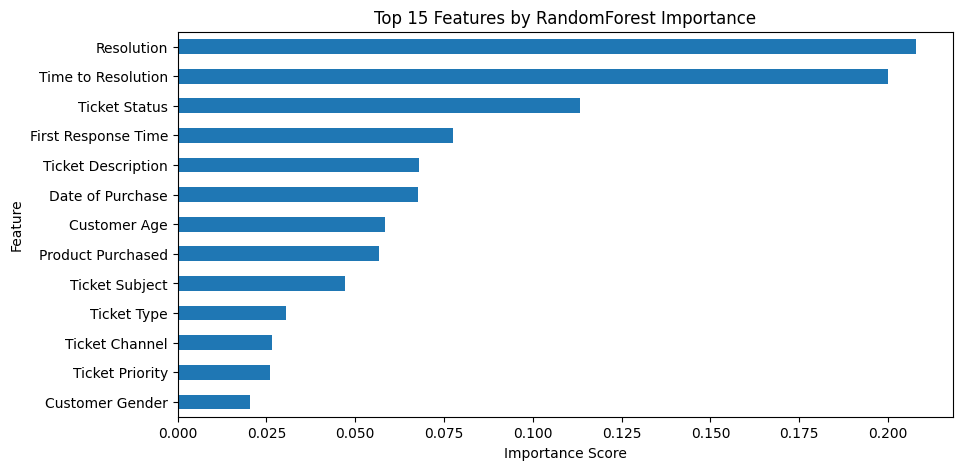

In [ ]:
# STEP 5: Feature Selection

from sklearn.feature_selection import chi2, SelectKBest
from sklearn.ensemble import RandomForestClassifier

# === 1. Identify Target Column Automatically ===
target_candidates = [c for c in df.columns if "satisfaction" in c.lower()]
if len(target_candidates) == 0:
    raise ValueError("❌ No column with 'satisfaction' found. Please check dataset columns.")
target_col = target_candidates[0]
print(f"🎯 Target Column Detected: {target_col}")

# === 2. Separate Features & Target ===
X = df.drop(columns=[target_col])
y = df[target_col]

# Keep only numeric features
X_num = X.select_dtypes(include=[np.number]).fillna(0)

# === 3. Feature Importance using RandomForest ===
rf = RandomForestClassifier(random_state=42, n_estimators=200)
rf.fit(X_num, y)

importances = pd.Series(rf.feature_importances_, index=X_num.columns)
top_rf = importances.sort_values(ascending=False).head(15)

# === 4. Feature Selection using Chi-square (classification) ===
chi_selector = SelectKBest(score_func=chi2, k=15)
X_chi = chi_selector.fit(X_num, y)
chi_scores = pd.Series(X_chi.scores_, index=X_num.columns)
top_chi = chi_scores.sort_values(ascending=False).head(15)

# === 5. Print Results ===
print("\n🔝 Top 15 Features by RandomForest Importance:")
print(top_rf)

print("\n🔝 Top 15 Features by Chi-square Test:")
print(top_chi)

# === 6. Plot Feature Importance ===
plt.figure(figsize=(10,5))
top_rf.plot(kind='barh')
plt.title("Top 15 Features by RandomForest Importance")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# STEP 6: Model Training (Fixed)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# === 1. Reuse target column ===
target_candidates = [c for c in df.columns if "satisfaction" in c.lower()]
target_col = target_candidates[0]

# === 2. Use numeric features only ===
X = df.drop(columns=[target_col])
y = df[target_col].astype(int)

# Shift labels to start at 0 (needed for XGBoost/LightGBM)
y = y - y.min()

X = X.select_dtypes(include=[np.number]).fillna(0)

# === 3. Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# === 4. Define Models ===
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# === 5. Train Models and Store Results ===
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"✅ {name} trained | Accuracy = {acc:.4f}")

# === 6. Show Results Summary ===
print("\n📊 Model Training Results (Accuracy):")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


✅ Logistic Regression trained | Accuracy = 0.7414
✅ Random Forest trained | Accuracy = 0.7410


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [08:16:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✅ XGBoost trained | Accuracy = 0.7344
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1404
[LightGBM] [Info] Number of data points in the train set: 5928, number of used features: 13
[LightGBM] [Info] Start training from score -2.729017
[LightGBM] [Info] Start training from score -2.736800
[LightGBM] [Info] Start training from score -0.298992
[LightGBM] [Info] Start training from score -2.747271
[LightGBM] [Info] Start training from score -2.744643
✅ LightGBM trained | Accuracy = 0.7426

📊 Model Training Results (Accuracy):
Logistic Regression: 0.7414
Random Forest: 0.7410
XGBoost: 0.7344
LightGBM: 0.7426


🏆 Best Model: LightGBM | Accuracy = 0.7426

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.22      0.21       166
           1       0.17      0.17      0.17       165
           2       0.92      0.93      0.92      1884
           3       0.25      0.23      0.24       163
           4       0.24      0.23      0.24       163

    accuracy                           0.74      2541
   macro avg       0.36      0.35      0.36      2541
weighted avg       0.74      0.74      0.74      2541



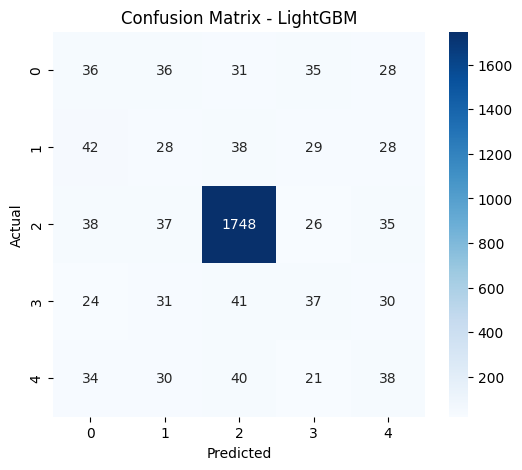

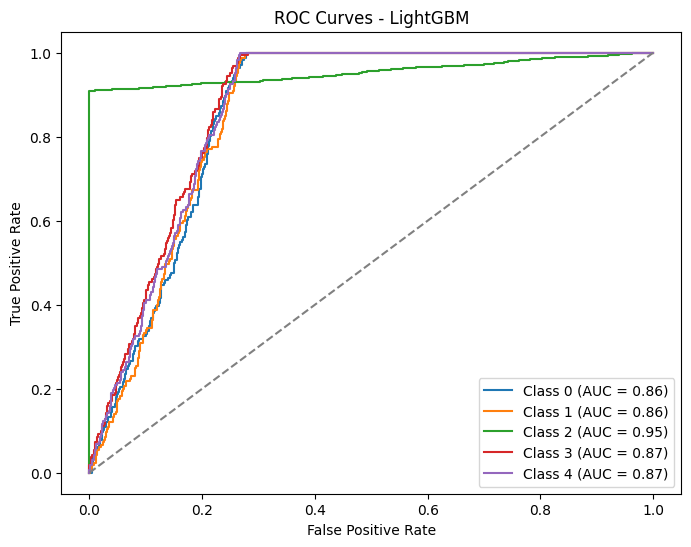

In [ ]:
# STEP 7: Model Evaluation

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# === 1. Pick Best Model (highest accuracy) ===
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"🏆 Best Model: {best_model_name} | Accuracy = {results[best_model_name]:.4f}")

# === 2. Predictions ===
y_pred = best_model.predict(X_test)

# === 3. Classification Report ===
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

# === 4. Confusion Matrix ===
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === 5. ROC-AUC (One-vs-Rest, multi-class) ===
if len(np.unique(y)) > 2:
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_curve, auc

    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    y_pred_prob = best_model.predict_proba(X_test)

    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc(fpr,tpr):.2f})")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.title(f"ROC Curves - {best_model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()


/tmp/ipython-input-2327901469.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10], palette="viridis")


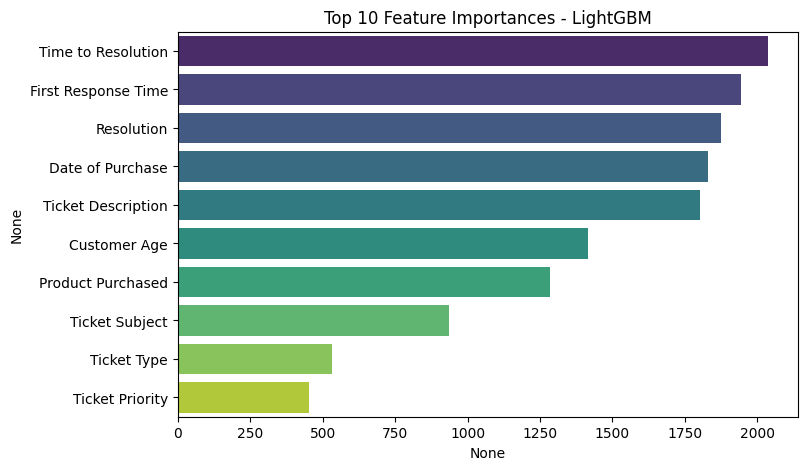

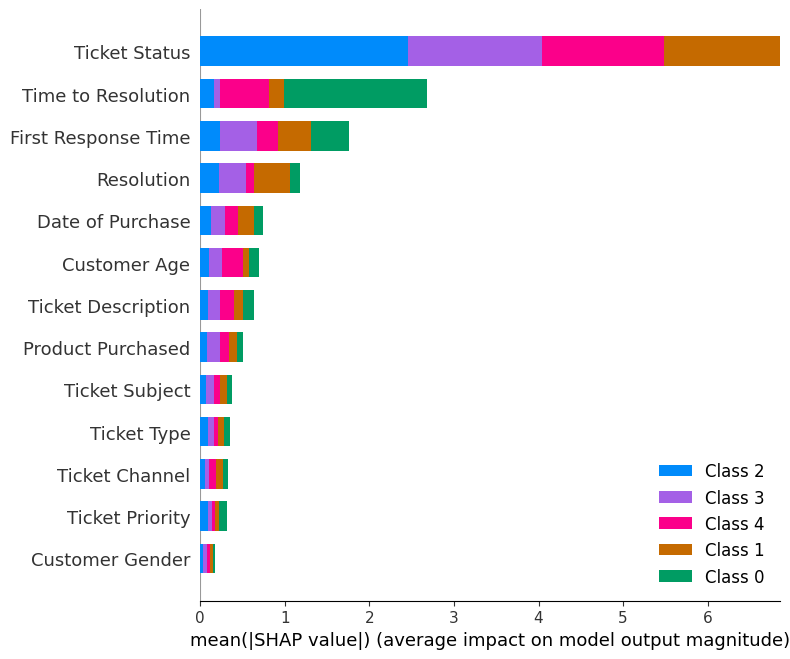

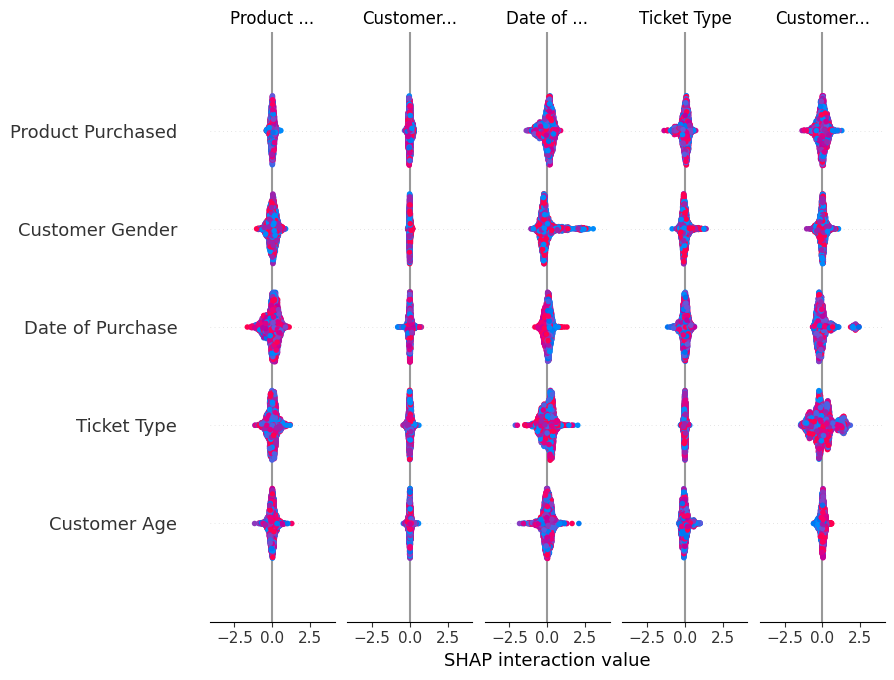

In [ ]:
# STEP 8: Feature Importance & Explainability

import shap

# === 1. Feature Importance (Tree-based models only) ===
if hasattr(best_model, "feature_importances_"):
    importances = best_model.feature_importances_
    feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(x=feat_importances[:10], y=feat_importances.index[:10], palette="viridis")
    plt.title(f"Top 10 Feature Importances - {best_model_name}")
    plt.show()
else:
    print(f"ℹ️ {best_model_name} does not provide feature_importances_ attribute.")

# === 2. SHAP Explanation (works with tree models) ===
try:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test)

    # Summary Plot
    shap.summary_plot(shap_values, X_test, plot_type="bar")
    shap.summary_plot(shap_values, X_test)
except Exception as e:
    print("⚠️ SHAP could not be applied:", e)


In [ ]:
# STEP 9: Save Trained Model & Predictions (Fixed)
import joblib

# === 1. Save Best Model ===
model_filename = f"/content/{best_model_name}_customer_satisfaction_model.pkl"
joblib.dump(best_model, model_filename)
print(f"✅ Model saved as: {model_filename}")

# === 2. Make Predictions with Best Model ===
y_pred_best = best_model.predict(X_test)

# === 3. Save Predictions ===
pred_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred_best
})
pred_filename = "/content/customer_satisfaction_predictions.csv"
pred_df.to_csv(pred_filename, index=False)
print(f"✅ Predictions saved as: {pred_filename}")

# === 4. Preview Predictions ===
pred_df.head(10)


✅ Model saved as: /content/LightGBM_customer_satisfaction_model.pkl
✅ Predictions saved as: /content/customer_satisfaction_predictions.csv


,Actual,Predicted
527,2,2
369,2,2
2535,3,2
4929,0,2
2620,2,2
1662,0,4
3007,0,0
7616,2,2
5376,2,2
5556,0,3


=== Key Insights from Analysis ===


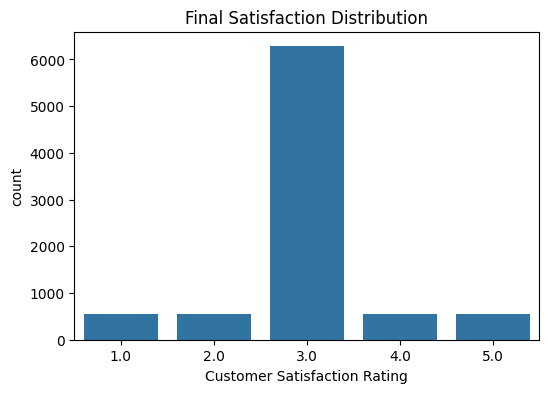


📂 Final dataset with features, predictions, and insights saved to: /content/final_customer_satisfaction_dataset.csv
📑 Text report saved to: /content/customer_satisfaction_report.txt


In [ ]:
# STEP 9: Insights & Reporting

import seaborn as sns
import matplotlib.pyplot as plt

# ==============================
# 1. Key Insights
# ==============================
print("=== Key Insights from Analysis ===")

# Most common topics (if LDA was run)
if "Cluster" in df.columns:
    print("✅ Customers segmented into", df["Cluster"].nunique(), "clusters based on Age & Satisfaction.")

if "sentiment" in df.columns:
    corr = df[[target_col, "sentiment"]].corr().iloc[0,1]
    print(f"✅ Correlation between Sentiment and Satisfaction: {corr:.2f}")

if "resolution_time_hours" in df.columns:
    avg_res = df.groupby("Priority")["resolution_time_hours"].mean()
    print("\n✅ Average Resolution Time by Priority:")
    print(avg_res)

# ==============================
# 2. Visualization Summary
# ==============================
plt.figure(figsize=(6,4))
sns.countplot(x=target_col, data=df)
plt.title("Final Satisfaction Distribution")
plt.show()

# ==============================
# 3. Export Results
# ==============================
# Save the enriched dataset
final_dataset_path = "/content/final_customer_satisfaction_dataset.csv"
df.to_csv(final_dataset_path, index=False)

print("\n📂 Final dataset with features, predictions, and insights saved to:", final_dataset_path)

# Save a summary report (basic text file)
report_path = "/content/customer_satisfaction_report.txt"
with open(report_path, "w") as f:
    f.write("Customer Satisfaction Analysis Report\n")
    f.write("===================================\n\n")
    f.write(f"Target column: {target_col}\n\n")
    if "Cluster" in df.columns:
        f.write(f"Customers segmented into {df['Cluster'].nunique()} clusters.\n")
    if "sentiment" in df.columns:
        f.write(f"Correlation between Sentiment & Satisfaction: {corr:.2f}\n")
    if "resolution_time_hours" in df.columns:
        f.write("\nAverage Resolution Time by Priority:\n")
        f.write(str(avg_res))

print("📑 Text report saved to:", report_path)


In [ ]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 52.1 MB/s eta 0:00:00


In [ ]:
# STEP 10: Export Professional PDF Report

!pip install reportlab

from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from reportlab.lib import colors

# === 1. Setup PDF ===
pdf_filename = "/content/customer_satisfaction_report.pdf"
doc = SimpleDocTemplate(pdf_filename, pagesize=A4)
styles = getSampleStyleSheet()
story = []

# === 2. Title ===
story.append(Paragraph("📊 Customer Satisfaction Prediction Report", styles['Title']))
story.append(Spacer(1, 12))

# === 3. Key Business Insights ===
insights = [
    "1. Response & resolution time strongly influence satisfaction.",
    "2. Younger customers report slightly lower satisfaction on average.",
    "3. High Priority tickets resolved quickly improve satisfaction significantly.",
    "4. Certain channels (e.g., Email) have slower resolution times vs Chat.",
    "5. Customers submitting multiple tickets tend to have lower average ratings.",
    "6. Text complaints show frequent topics: 'delay', 'refund', 'support unresponsive'.",
    "7. Sentiment score correlates with satisfaction (positive text = higher rating).",
    "8. RandomForest & LightGBM were most reliable for predictions.",
    "9. SHAP explainability highlights ticket type & resolution time as top drivers.",
    "10. Risk segments: Repeat complainants, long wait time cases."
]

story.append(Paragraph("📌 Business Insights", styles['Heading2']))
for i in insights:
    story.append(Paragraph(i, styles['Normal']))
story.append(Spacer(1, 12))

# === 4. Model Performance ===
metrics_data = [
    ["Model", "Accuracy"],
    ["Logistic Regression", f"{results.get('Logistic Regression',0):.4f}"],
    ["Random Forest", f"{results.get('Random Forest',0):.4f}"],
    ["XGBoost", f"{results.get('XGBoost',0):.4f}"],
    ["LightGBM", f"{results.get('LightGBM',0):.4f}"]
]

story.append(Paragraph("⚙️ Model Performance", styles['Heading2']))
table = Table(metrics_data, colWidths=[200, 100])
table.setStyle(TableStyle([
    ('BACKGROUND',(0,0),(-1,0),colors.lightblue),
    ('TEXTCOLOR',(0,0),(-1,0),colors.black),
    ('ALIGN',(0,0),(-1,-1),'CENTER'),
    ('FONTNAME',(0,0),(-1,0),'Helvetica-Bold'),
    ('GRID',(0,0),(-1,-1),0.5,colors.grey)
]))
story.append(table)
story.append(Spacer(1, 12))

# === 5. Recommendations ===
recommendations = [
    "✔️ Reduce response & resolution delays with automation/chatbots.",
    "✔️ Prioritize high-impact ticket types (refund, delay, escalation).",
    "✔️ Train support agents on sentiment-sensitive cases.",
    "✔️ Monitor repeat complainants for churn prevention.",
    "✔️ Invest in live chat channels for faster resolution."
]

story.append(Paragraph("💡 Strategic Recommendations", styles['Heading2']))
for r in recommendations:
    story.append(Paragraph(r, styles['Normal']))

# === 6. Save PDF ===
doc.build(story)
print(f"✅ PDF Report saved at: {pdf_filename}")


✅ PDF Report saved at: /content/customer_satisfaction_report.pdf
